In [27]:
import torch
from torch import nn
import torch.nn.functional as F 
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torch.utils import data
from torchvision import transforms
import glob  
from PIL import Image

In [28]:
torch.cuda.is_available()

True

In [29]:
imgs_path = glob.glob('../input/anime-sketch-colorization-pair/data/train/*.png') 

In [30]:
len(imgs_path)

14224

In [31]:
imgs_path[:4]

['../input/anime-sketch-colorization-pair/data/train/2041115.png',
 '../input/anime-sketch-colorization-pair/data/train/2909140.png',
 '../input/anime-sketch-colorization-pair/data/train/179059.png',
 '../input/anime-sketch-colorization-pair/data/train/2084052.png']

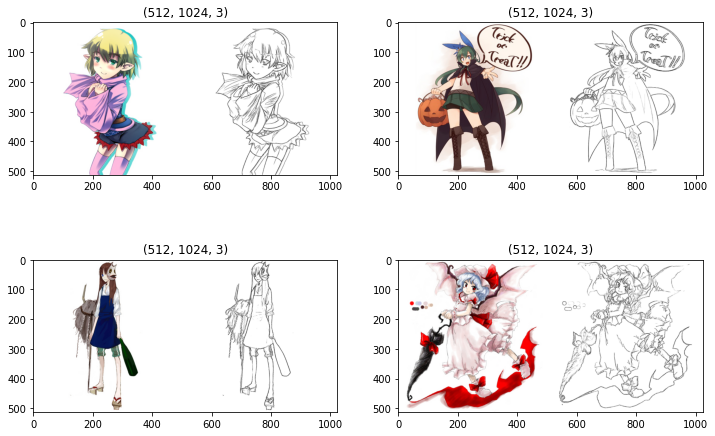

In [32]:
plt.figure(figsize=(12,8))
for i, img_path in enumerate(imgs_path[:4]):
    img = Image.open(img_path)  
    img = img.convert('RGB') 
    np_img = np.array(img)
    plt.subplot(2, 2, i+1)
    plt.imshow(np_img)
    plt.title(str(np_img.shape))
plt.show()

In [33]:

transform = transforms.Compose([
    transforms.ToTensor(),  
    transforms.Resize((256, 512)),  
    transforms.Normalize(0.5, 0.5)  
])

In [34]:

class Anime_dataset(data.Dataset):
    def __init__(self, imgs_path):
        self.imgs_path = imgs_path

    def __getitem__(self, index): 
        img_path = self.imgs_path[index] 
        pil_img = Image.open(img_path)  
        pil_img = pil_img.convert('RGB')  
        pil_img = transform(pil_img) 
        w = pil_img.size(2) // 2  
        return pil_img[:, :, w:], pil_img[:, :, :w] 

    def __len__(self):
        return len(self.imgs_path) 

In [35]:
dataset = Anime_dataset(imgs_path)
print(len(dataset))
batchsize = 64
dataloader = data.DataLoader(dataset, batch_size=batchsize, shuffle=True, pin_memory=True)

14224


torch.Size([64, 3, 256, 256])


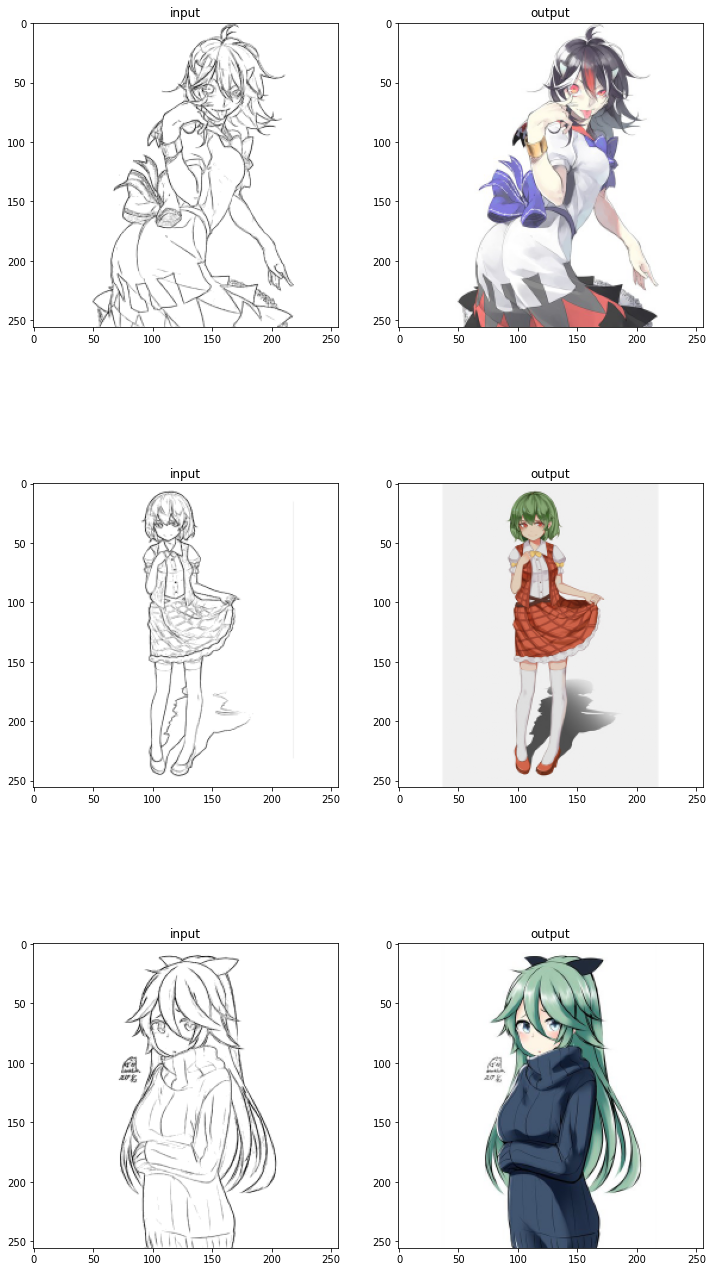

In [36]:

imgs_batch, masks_batch = next(iter(dataloader))
print(imgs_batch.shape)

plt.figure(figsize=(12, 24))
for i, (img, mask) in enumerate(zip(imgs_batch[:3], masks_batch[:3])):
    img = (img.permute(1, 2, 0).numpy() + 1) / 2
    mask = (mask.permute(1, 2, 0).numpy() + 1) / 2
    plt.subplot(3, 2, 2*i+1)
    plt.title('input')
    plt.imshow(img)
    plt.subplot(3, 2, 2 * i + 2)
    plt.title('output')
    plt.imshow(mask)

plt.show()

In [37]:

class Downsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Downsample, self).__init__()
        self.conv_relu = nn.Sequential(  
            nn.Conv2d(in_channels, out_channels, 
                      kernel_size=3,
                      stride=2,
                      padding=1),
            nn.LeakyReLU(inplace=True), 
        )
        self.bn = nn.BatchNorm2d(out_channels)

    
    def forward(self, x, is_bn=True):
        x = self.conv_relu(x)  
        if is_bn:  
            x = self.bn(x)
        return x

In [38]:

class Upsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Upsample, self).__init__()
        self.upconv_relu = nn.Sequential( 
            nn.ConvTranspose2d(in_channels, out_channels,  
                               kernel_size=3,
                               stride=2,
                               padding=1,
                               output_padding=1),
            nn.LeakyReLU(inplace=True),  
        )
        self.bn = nn.BatchNorm2d(out_channels)

   
    def forward(self, x, is_drop=False):
        x = self.upconv_relu(x)  
        x = self.bn(x)  
        if is_drop:  
            x = F.dropout2d(x)
        return x

In [39]:

class Generator(nn.Module):  
    def __init__(self):
        super(Generator, self).__init__()
        
        self.down1 = Downsample(3, 64)  
        self.down2 = Downsample(64, 128)  
        self.down3 = Downsample(128, 256) 
        self.down4 = Downsample(256, 512)  
        self.down5 = Downsample(512, 512)  
        self.down6 = Downsample(512, 512) 

       
        self.up1 = Upsample(512, 512)  
       
        self.up2 = Upsample(1024, 512) 
        self.up3 = Upsample(1024, 256)  
        self.up4 = Upsample(512, 128)  
        self.up5 = Upsample(256, 64)  

        self.last = nn.ConvTranspose2d(128, 3,
                                       kernel_size=3,
                                       stride=2,
                                       padding=1,
                                       output_padding=1)

    def forward(self, x):  
        
        x1 = self.down1(x)  
        x2 = self.down2(x1)  
        x3 = self.down3(x2) 
        x4 = self.down4(x3)  
        x5 = self.down5(x4) 
        x6 = self.down6(x5)  
       
      
        x6 = self.up1(x6, is_drop=True) 
        x6 = torch.cat([x6, x5], dim=1)  

        x6 = self.up2(x6, is_drop=True)  
        x6 = torch.cat([x6, x4], dim=1)  

        x6 = self.up3(x6, is_drop=True) 
        x6 = torch.cat([x6, x3], dim=1) 

      
        x6 = self.up4(x6) 
        x6 = torch.cat([x6, x2], dim=1)

        x6 = self.up5(x6)  
        x6 = torch.cat([x6, x1], dim=1)  
       
        x = torch.tanh(self.last(x6))  
        return x

In [40]:

class Discriminator(nn.Module):  
    def __init__(self):
        super(Discriminator, self).__init__()
      
        self.down1 = Downsample(6, 64) 
        self.down2 = Downsample(64, 128)  
        self.cov1 = nn.Conv2d(128, 256, kernel_size=3)  
        self.bn = nn.BatchNorm2d(256)
        self.last = nn.Conv2d(256, 1, kernel_size=3)  

    def forward(self, img, mask):  
        x = torch.cat([img, mask], dim=1)  
        x = self.down1(x, is_bn=False)  
        x = self.down2(x)
        x = F.dropout2d(self.bn(F.leaky_relu(self.cov1(x)))) 
        x = torch.sigmoid(self.last(x)) 
        return x

In [41]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'
G = Generator().to(device)  
D = Discriminator().to(device)  

G_optim = torch.optim.Adam(G.parameters(), lr=1e-3, betas=(0.5, 0.999))
D_optim = torch.optim.Adam(D.parameters(), lr=1e-4, betas=(0.5, 0.999)) 

In [42]:

loss1 = torch.nn.BCELoss()
loss2 = torch.nn.L1Loss()
LAMBDA = 7  

In [43]:

def gen_img_plot(model, img, mask):  

    predictions = np.squeeze(model(img).permute(0, 2, 3, 1).detach().cpu().numpy())  
    img = img.permute(0, 2, 3, 1).cpu().numpy()
    mask = mask.permute(0, 2, 3, 1).cpu().numpy()
    plt.figure(figsize=(10, 10))  
    display_list = [img[0], mask[0], predictions[0]]
    title = ['Input', 'truth', 'Output']
    for i in range(3): 
        plt.subplot(1, 3, i + 1) 
        plt.title(title[i])
       
        plt.imshow((display_list[i] + 1) / 2)
        plt.axis('off') 
    
    plt.show() 

In [44]:

imgs_path_test = glob.glob('../input/anime-sketch-colorization-pair/data/val/*.png')  
test_dataset = Anime_dataset(imgs_path_test)
test_dataloader = data.DataLoader(dataset, batch_size=batchsize)
imgs_batch, masks_batch = next(iter(test_dataloader))  

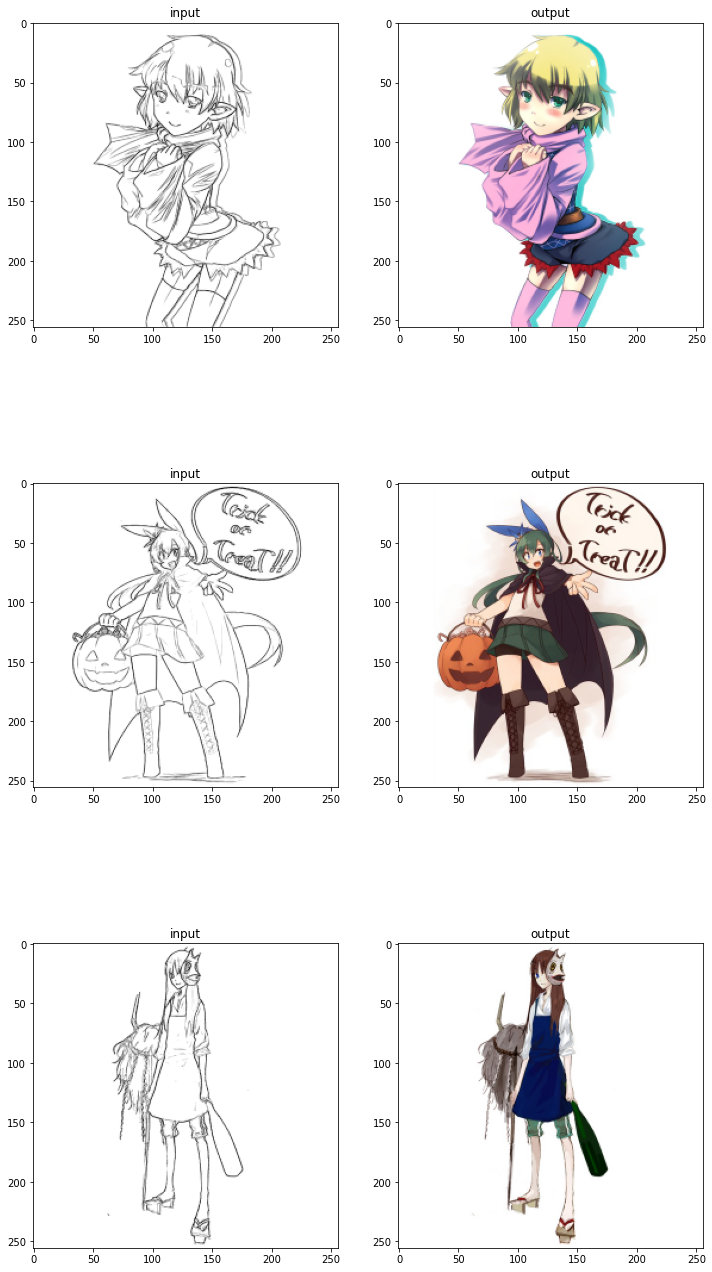

In [45]:
plt.figure(figsize=(12, 24))
for i, (img, mask) in enumerate(zip(imgs_batch[:3], masks_batch[:3])):
    img = (img.permute(1, 2, 0).numpy() + 1) / 2
    mask = (mask.permute(1, 2, 0).numpy() + 1) / 2
    plt.subplot(3, 2, 2*i+1)
    plt.title('input')
    plt.imshow(img)
    plt.subplot(3, 2, 2 * i + 2)
    plt.title('output')
    plt.imshow(mask)

plt.show()
imgs_batch = imgs_batch.to(device)
masks_batch = masks_batch.to(device)

In [46]:
D_loss_list = [] 
G_loss_list = []

Epoch: 0


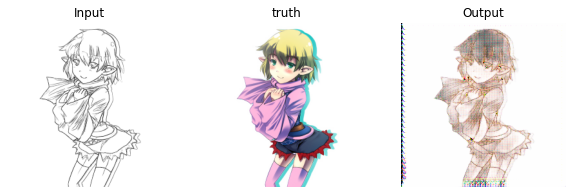

Epoch: 1


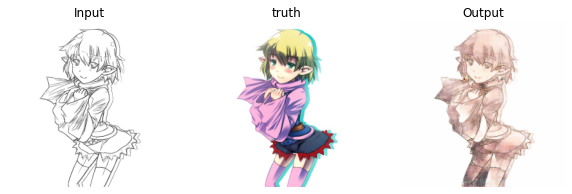

Epoch: 2


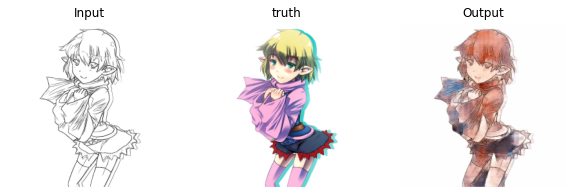

Epoch: 3


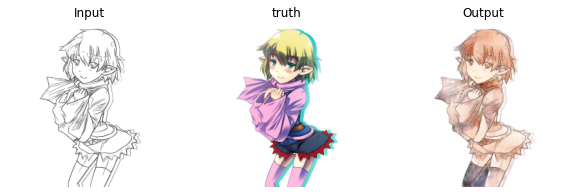

Epoch: 4


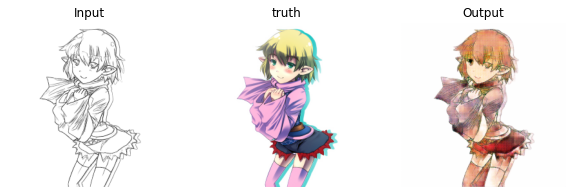

Epoch: 5


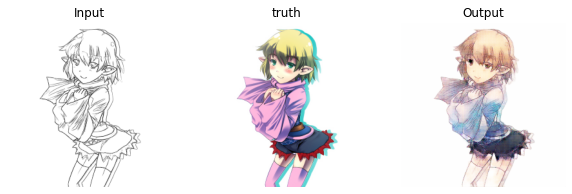

Epoch: 6


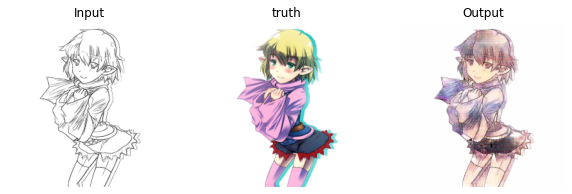

Epoch: 7


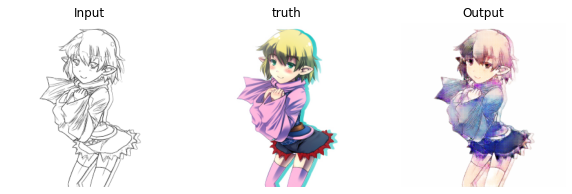

Epoch: 8


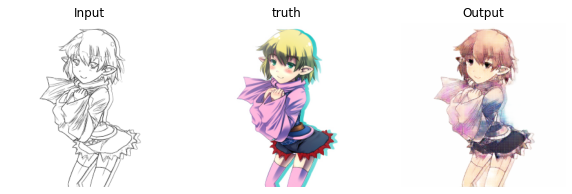

Epoch: 9


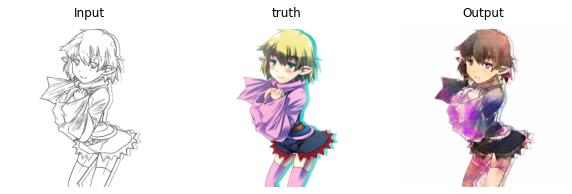

Epoch: 10


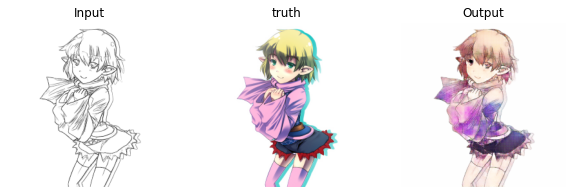

Epoch: 11


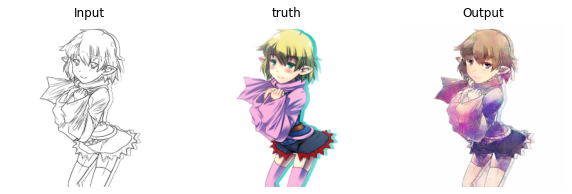

Epoch: 12


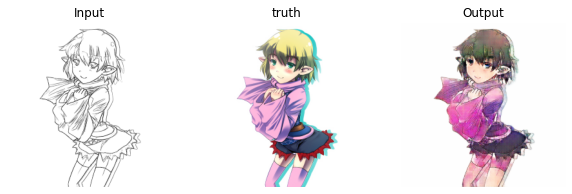

Epoch: 13


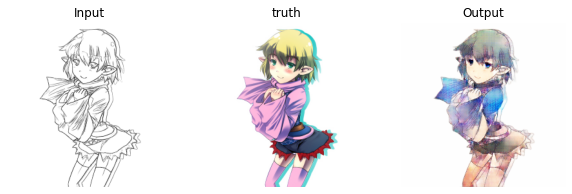

Epoch: 14


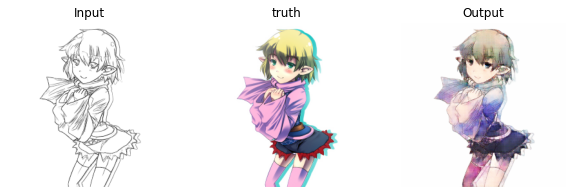

Epoch: 15


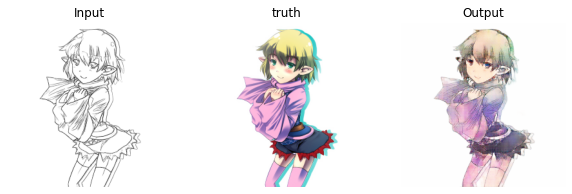

Epoch: 16


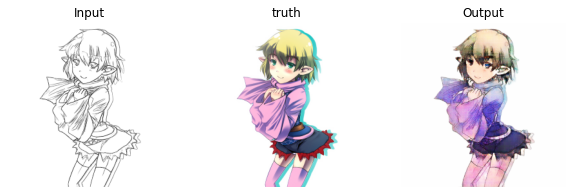

Epoch: 17


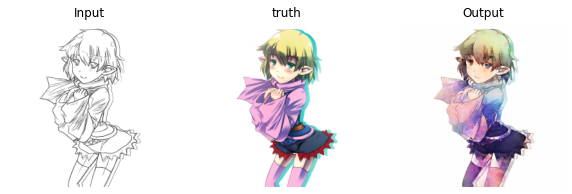

Epoch: 18


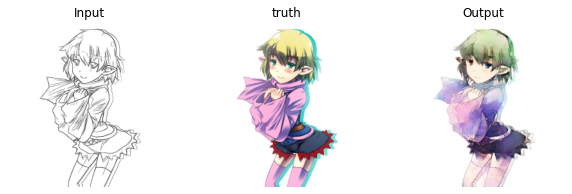

Epoch: 19


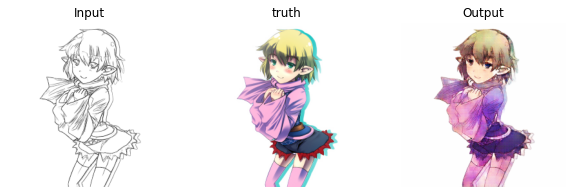

Epoch: 20


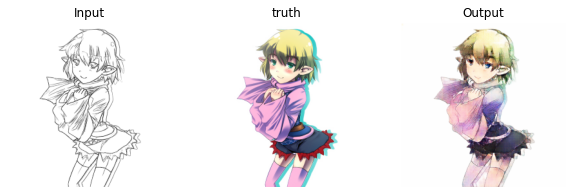

Epoch: 21


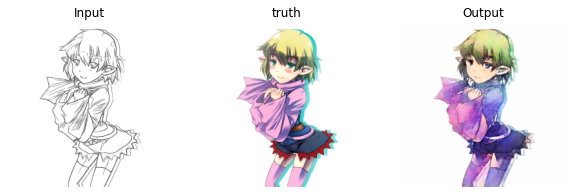

Epoch: 22


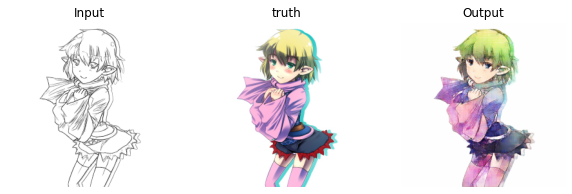

Epoch: 23


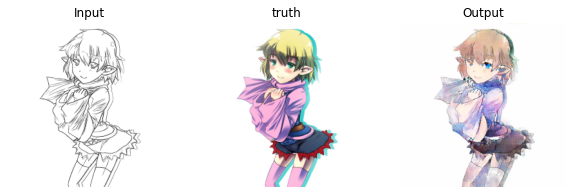

Epoch: 24


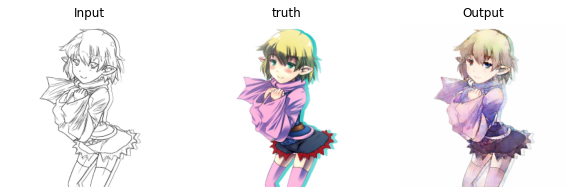

Epoch: 25


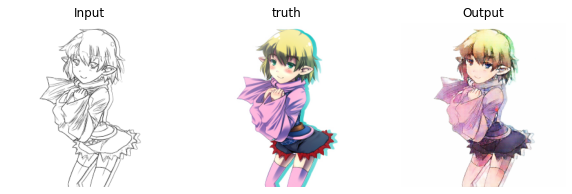

Epoch: 26


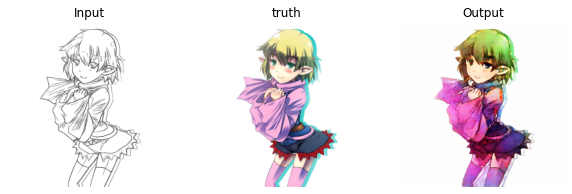

Epoch: 27


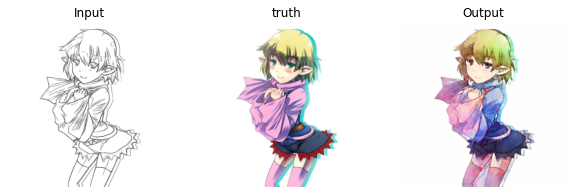

Epoch: 28


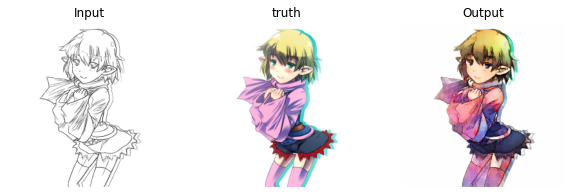

Epoch: 29


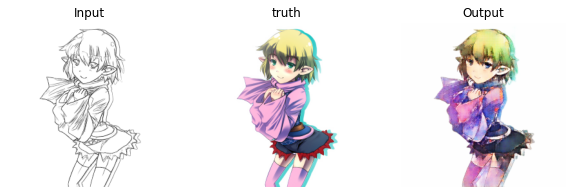

Epoch: 30


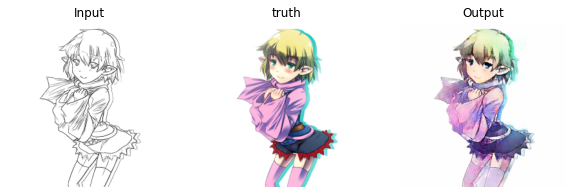

Epoch: 31


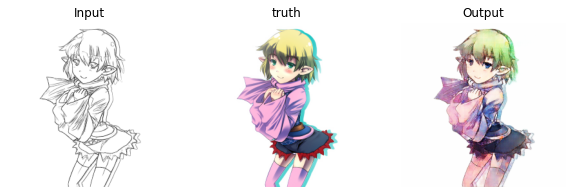

Epoch: 32


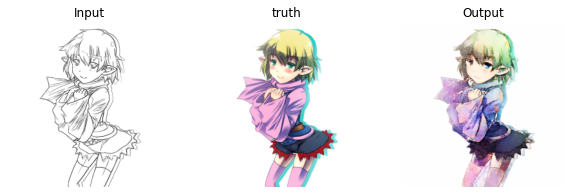

Epoch: 33


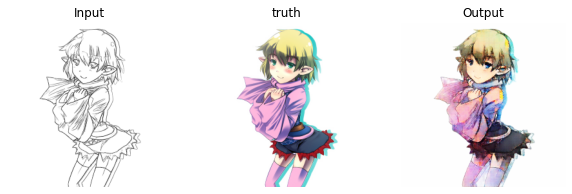

Epoch: 34


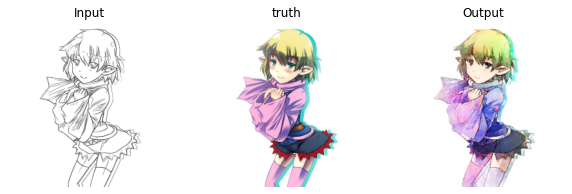

Epoch: 35


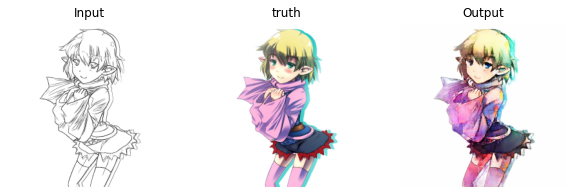

Epoch: 36


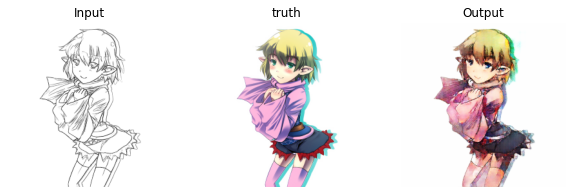

Epoch: 37


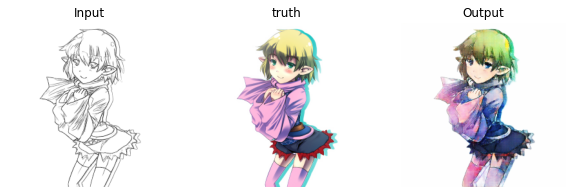

Epoch: 38


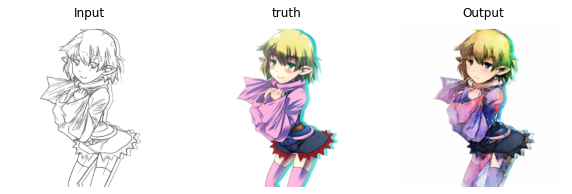

Epoch: 39


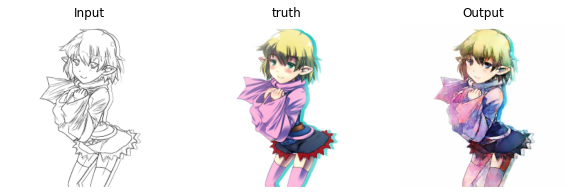

Epoch: 40


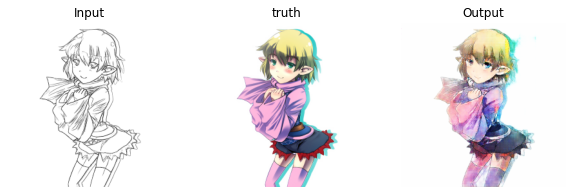

Epoch: 41


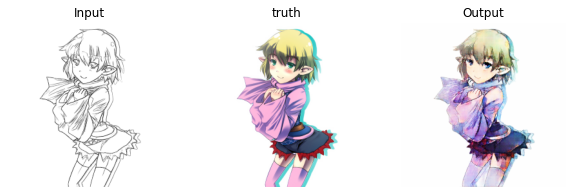

Epoch: 42


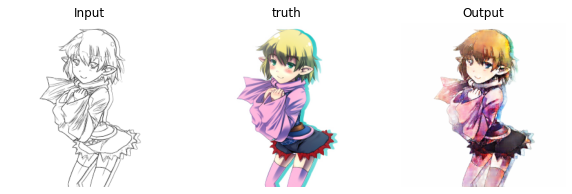

Epoch: 43


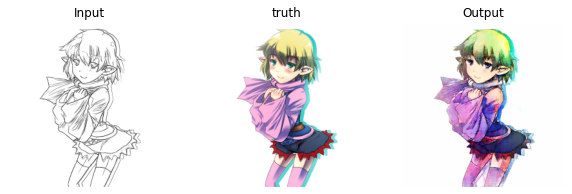

Epoch: 44


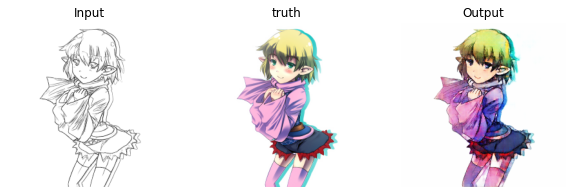

Epoch: 45


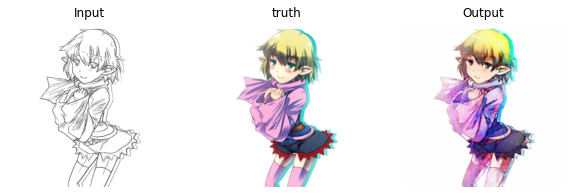

Epoch: 46


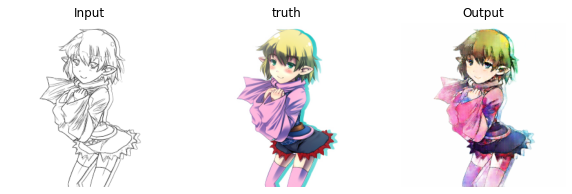

Epoch: 47


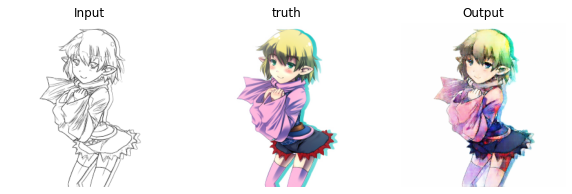

Epoch: 48


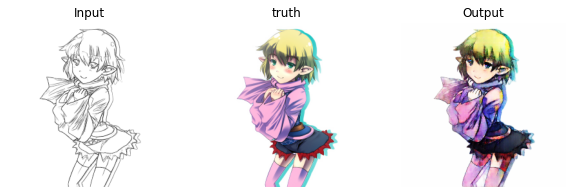

Epoch: 49


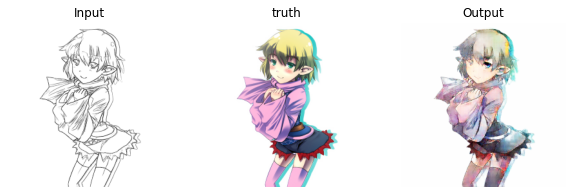

Epoch: 50


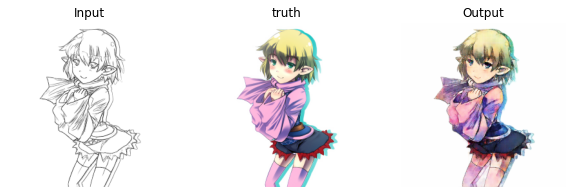

Epoch: 51


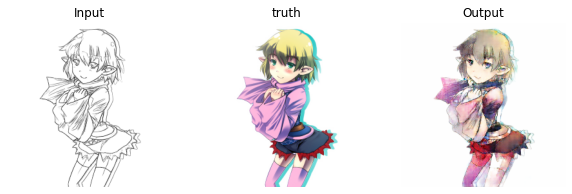

Epoch: 52


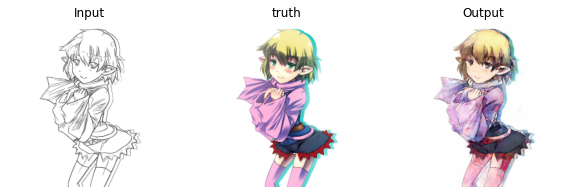

Epoch: 53


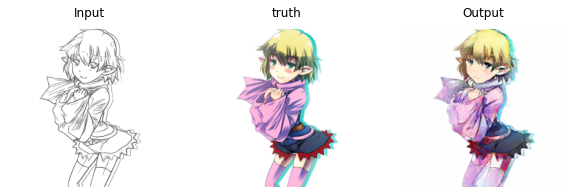

Epoch: 54


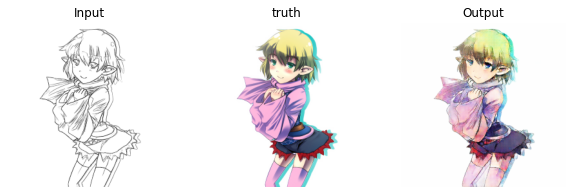

Epoch: 55


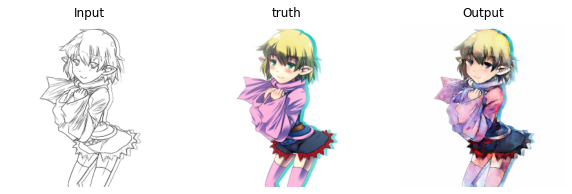

Epoch: 56


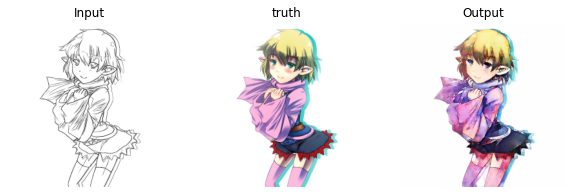

Epoch: 57


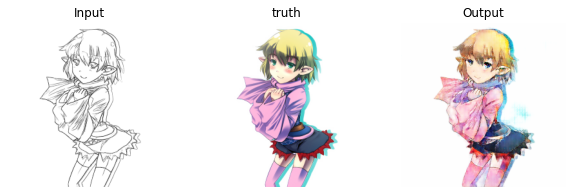

Epoch: 58


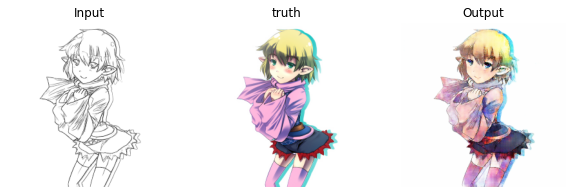

Epoch: 59


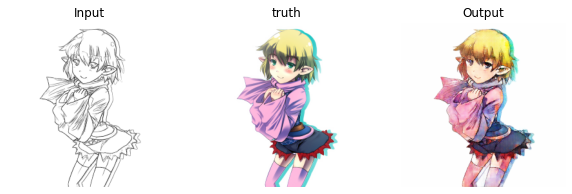

Epoch: 60


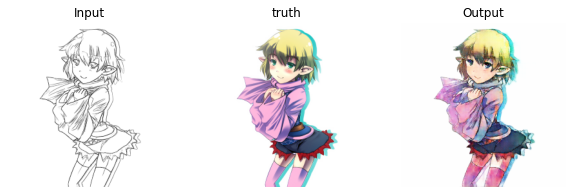

Epoch: 61


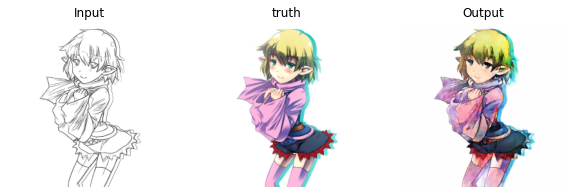

Epoch: 62


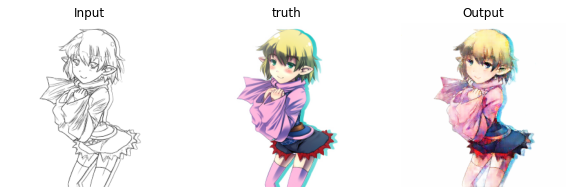

Epoch: 63


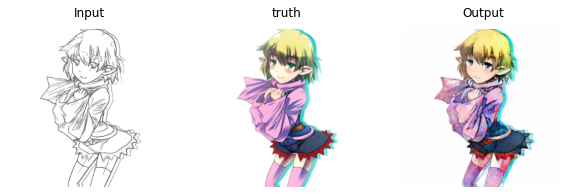

Epoch: 64


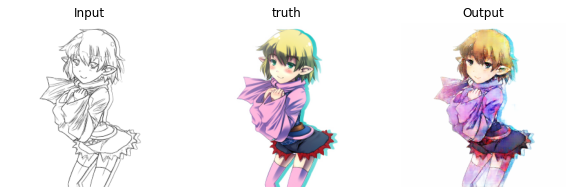

Epoch: 65


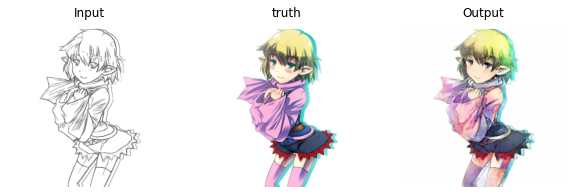

Epoch: 66


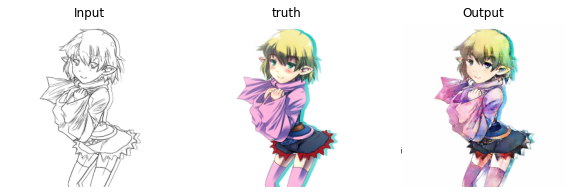

Epoch: 67


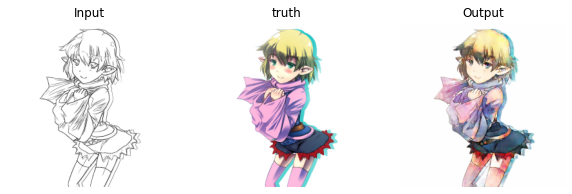

In [47]:
for epoch in range(68):
    D_epoch_loss = 0  
    G_epoch_loss = 0
    count = len(dataloader)  
    for step, (imgs, masks) in enumerate(dataloader):
        imgs = imgs.to(device)
        masks = masks.to(device)
        D_optim.zero_grad() 
        D_real = D(imgs, masks)  
        D_real_loss = loss1(D_real, torch.ones_like(D_real))  
        D_real_loss.backward()  
        G_img = G(imgs)  
    
        D_fake = D(imgs, G_img.detach())
        D_fake_loss = loss1(D_fake, torch.zeros_like(D_fake)) 
        D_fake_loss.backward()  
       
        D_loss = D_real_loss + D_fake_loss 
        D_optim.step()  

        
        G_loss = 0
        for _ in range(3):
            G_optim.zero_grad()  
            G_img = G(imgs) 
           
            D_fake = D(imgs, G_img)  
           
            G_loss_BEC = loss1(D_fake, torch.ones_like(D_fake)) 
            G_loss_L1 = loss2(G_img, masks)  
          
            G_loss = G_loss_BEC + LAMBDA * G_loss_L1
            G_loss.backward() 
            G_optim.step()  

     
        with torch.no_grad():
            D_epoch_loss += D_loss.item()  
            G_epoch_loss += G_loss.item()


    with torch.no_grad(): 
        D_epoch_loss /= count
        G_epoch_loss /= count
        D_loss_list.append(D_epoch_loss)
        G_loss_list.append(G_epoch_loss)
        print('Epoch:', epoch)
        gen_img_plot(G, imgs_batch, masks_batch)

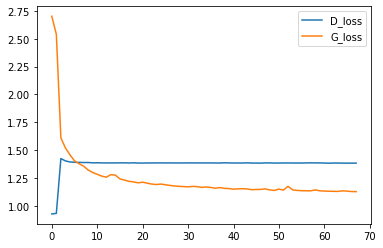

In [48]:

plt.plot(D_loss_list, label='D_loss')
plt.plot(G_loss_list, label='G_loss')
plt.legend()
plt.show()

In [49]:
torch.save(G.state_dict(), 'state_dict.pt')
torch.save(G, 'G.pt')